In [1]:
import os

import numpy as np
import qiskit.ignis.mitigation.measurement as mc
from dotenv import load_dotenv
from numpy import pi
from qiskit import (IBMQ, Aer, ClassicalRegister, QuantumCircuit,
                    QuantumRegister, execute, transpile)
from qiskit.ignis.verification.tomography import (StateTomographyFitter,
                                                  state_tomography_circuits)
from qiskit.providers.aer import AerSimulator, noise
from qiskit.providers.ibmq.managed import IBMQJobManager

load_dotenv()
# IBMQ


True

In [2]:
# IBMQ.ibmq.save_account(os.environ['TOKEN'], overwrite=True)
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = provider = IBMQ.get_provider(group='open', project='main')

backend = provider.get_backend('ibmqx2')
# backend = AerSimulator.from_backend(backend)

In [4]:
from qiskit.providers.ibmq.job import job_monitor

# Parameters

In [5]:
gain_amp = 1
loss_amp = 0.1
m = min(loss_amp, gain_amp)

detuning = 3 * m
signal_strength = 2 * m
dt = 0.5

theta_d = 2*np.arcsin(np.sqrt(loss_amp * dt))
theta_g = 2*np.arcsin(np.sqrt(gain_amp * dt))

# Circuit

In [6]:
def generate_circuit(dt, detuning, signal_strength, steps):
    z_arg = -detuning * dt / 2
    y_arg = -signal_strength * dt

    qreg_q = QuantumRegister(2, "q")
    creg_c = ClassicalRegister(1, "c")

    qc = QuantumCircuit(qreg_q, creg_c)

    for _ in range(steps):
        qc.u(z_arg, y_arg, z_arg, qreg_q[0])

        # Loss
        qc.cu(theta_d, 0, 0, 0, qreg_q[0], qreg_q[1])
        qc.cx(qreg_q[1], qreg_q[0])
        qc.measure(qreg_q[1], creg_c[0])
        qc.reset(qreg_q[1])

        # Gain
        qc.u(-pi, 0, 0, qreg_q[0])
        qc.cx(qreg_q[0], qreg_q[1])
        qc.cu(theta_g, 0, 0, 0, qreg_q[0], qreg_q[1])
        qc.cx(qreg_q[0], qreg_q[1])
        qc.u(pi, 0, 0, qreg_q[0])
        qc.measure(qreg_q[1], creg_c[0])
        qc.reset(qreg_q[1])
    
    return qc


In [7]:
circuits = [generate_circuit(dt, detuning, signal_strength, 1) for i in range(1, 36)]

qreg_q = QuantumRegister(2, "q")

circuits_with_tomo = [state_tomography_circuits(circuit, qreg_q[0]) for circuit in circuits]

compiled_circuits_with_tomo = [transpile(circuit, backend) for circuit in circuits_with_tomo]

C:\Users\Oliver\AppData\Roaming\Python\Python38\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:468: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += circuit
C:\Users\Oliver\AppData\Roaming\Python\Python38\site-packages\qiskit\circuit\quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
C:\Users\Oliver\AppData\Roaming\Python\Python38\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  ci

In [ ]:
job_manager = IBMQJobManager()

jobs = [job_manager.run(circuit, backend=backend, name=f"QSync_{i}") for i, circuit in enumerate(compiled_circuits_with_tomo)]

In [29]:
# Save job ids for later retrieval
with open('jobs.txt', 'w') as f:
    for job in jobs:
        id = job.job_set_id()
        f.write(f"{id}\n")

In [44]:
states = []

for job, circuit in zip(jobs, compiled_circuits_with_tomo):
    result = job.results().combine_results()
    tomo_state = StateTomographyFitter(result, circuit)
    states.append(tomo_state.fit())

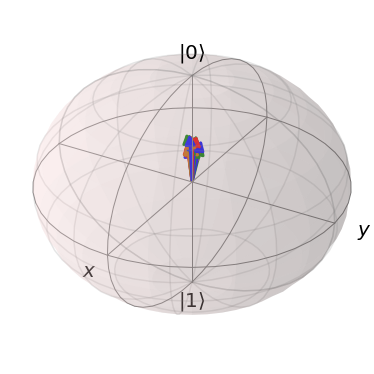

In [48]:
from qutip import Bloch3d, Bloch, Qobj

b = Bloch()

b.add_states([Qobj(s) for s in states])

b.show()